# **2110433 - Computer Vision (2023/2)**
#**Lab 8 - Convolutional Neural Network** <br>
In this lab, we will learn how to use Convolutional Neural Network to perform image classification in the provided real world dataset using PyTorch. This notebook includes both coding and written questions. Please hand in this notebook file with all outputs and your answer

In [1]:
import random
import numpy as np
import cv2
import pickle
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
from scipy.spatial.distance import cdist

# 1.Pixel as feature on CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Here are the  10 random images from class:
![CIFAR-10 samples image](https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/cifar-10-samples.png)

In [2]:
### CIFAR-10 dataset helper function ###

'''
data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
'''
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
def cifar10Loader(setName='train', datasetDir='cifar-10-batches-py/'):
  cifarImages = []
  cifarLabels = []

  if setName == 'train':
    fileNamePrefix = 'data_batch_'
    for batchNo in range(1,6):
      batchData = unpickle(datasetDir + fileNamePrefix + str(batchNo))
      cifarImages.append(batchData[b'data'])
      cifarLabels.append(batchData[b'labels'])
    cifarImages = np.concatenate(cifarImages)
    cifarLabels = np.concatenate(cifarLabels)
    return cifarImages, cifarLabels

  else:
    batchData = unpickle(datasetDir + 'test_batch')
    return batchData[b'data'], batchData[b'labels']

def cifar10Labels(datasetDir='cifar-10-batches-py/'):
  byteLabels = unpickle(datasetDir + 'batches.meta')[b'label_names']
  return [label.decode("utf-8")  for label in byteLabels]

## 1.1 Download and Inspect CIFAR-10 dataset

In [3]:
### Download and Extract CIFAR-10 Dataset ###
# !wget -O assets/Lab8/cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar xf assets/Lab8/cifar-10-python.tar.gz

In [4]:
cifarTrainImages, cifarTrainLabels = cifar10Loader(setName='train')
cifarTestImages, cifarTestLabels = cifar10Loader(setName='test')
cifarLabelNames = cifar10Labels()

cifarTrainImages = cifarTrainImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)
cifarTestImages = cifarTestImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)
totalTrainImages = len(cifarTrainLabels)
totalTestImages = len(cifarTestLabels)

print('Total train images :', totalTrainImages)
print('Total test images :', totalTestImages)
print('Labels :',cifarLabelNames)
print('cifarTrainImages shape :', cifarTrainImages.shape)
print('cifarTestImages shape :', cifarTestImages.shape)

Total train images : 50000
Total test images : 10000
Labels : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifarTrainImages shape : (50000, 32, 32, 3)
cifarTestImages shape : (10000, 32, 32, 3)


['automobile', 'deer', 'airplane', 'horse', 'truck', 'horse', 'horse', 'truck']


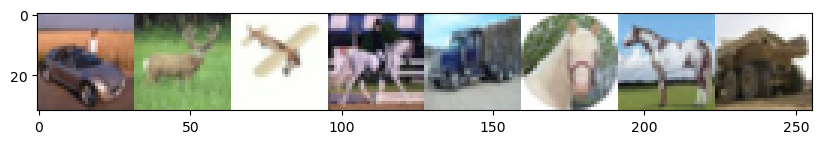

In [5]:
### Randomly show train images and their labels ###
randTrainIdx = random.sample(range(0, totalTrainImages), 8)
sampleTrainImages = np.concatenate([cifarTrainImages[idx, :] for idx in randTrainIdx],axis=1)

plt.figure(figsize=(10,10))
plt.imshow(sampleTrainImages, interpolation='nearest')
print([ cifarLabelNames[labelIdx] for labelIdx in cifarTrainLabels[randTrainIdx]])

## 1.2 CIFAR-10 classification using nearest neighbour


Sample image real label => automobile  Nearest label in train set => truck


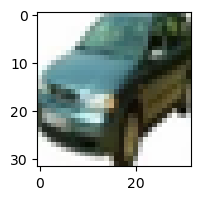

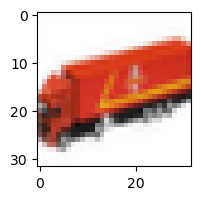

In [6]:
### Randomly pick a image from test set ###
randTestIdx = random.randint(0, totalTestImages) 
sampleTestImages = cifarTestImages[randTestIdx, :]

plt.figure(figsize=(2,2))
plt.imshow(sampleTestImages, interpolation='nearest')

### Find a nearest image from train set using euclidean distance ### 
distance = ((sampleTestImages - cifarTrainImages)**2).reshape(totalTrainImages,-1)
distance = np.sqrt(np.sum(distance,axis=1))
minDistance = np.min(distance)
minIdx = np.argmin(distance)

nearestTrainImage = cifarTrainImages[minIdx, :]

plt.figure(figsize=(2,2))
plt.imshow(nearestTrainImage, interpolation='nearest')
print('Sample image real label =>', cifarLabelNames[cifarTestLabels[randTestIdx]],' Nearest label in train set =>', cifarLabelNames[cifarTrainLabels[minIdx]])

#### The output result will be very bad ==> pixel as feature is not enough ###

# 2.Convolutional Neural Networks Building Block
![alt text](http://cs231n.github.io/assets/cnn/convnet.jpeg)
Image from CS231n Convolutional Neural Networks for Visual Recognition [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)

## 2.1 Convolution Layer

In [7]:
%%html
<iframe src="https://cs231n.github.io/assets/conv-demo/index.html" width="800" height="700"></iframe>

## 2.2 Pooling Layer
<br>
<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width="36%">
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="59%">

In [8]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

## 2.3 Get familiar with PyTorch layers

In [9]:
### Convolution & MaxPool operators in PyTorch ###
sampleInput = torch.tensor([[[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]]],dtype=torch.float32)
print(sampleInput)

print('=== Convolution ===')
kernel = torch.tensor([[[[1,1],[1,1]]]], dtype=torch.float32)
convOutput = F.conv2d(sampleInput, kernel, padding=0)
print(convOutput, convOutput.shape)

print('=== Maxpool ===')
maxPoolOutput = F.max_pool2d(sampleInput, kernel_size=2)
print(maxPoolOutput)

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
=== Convolution ===
tensor([[[[14., 18., 22.],
          [30., 34., 38.],
          [46., 50., 54.]]]]) torch.Size([1, 1, 3, 3])
=== Maxpool ===
tensor([[[[ 6.,  8.],
          [14., 16.]]]])


# 3.Example CNN real world usage : Fastener Classification

In [10]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix

# To guarantee reproducible results 
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2)

## 3.1 GPU status check

In [11]:
!nvidia-smi

Fri Mar 22 21:15:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        On  | 00000000:01:00.0  On |                  N/A |
|  0%   43C    P8              18W / 340W |    486MiB / 16376MiB |     26%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 3.2 Download and inspect train fastener dataset
You can download the dataset to your computer from [here](https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/fastenerDataset.zip)

In [12]:
### Download fastener dataset ###
# !wget  -O assets/Lab8/fastenerDataset.zip http://www.piclab.ai/classes/cv2020/fastenerDataset.zip
!unzip -qo assets/Lab8/fastenerDataset.zip

In [13]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [14]:
### Dataloader for our dataset ###
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
fastenerTrainDataset = ImageFolder('fastenerDataset/train/', transform=transform)
fastenerTestDataset = ImageFolder('fastenerDataset/test/', transform=transform)

print('Total train set images :', len(fastenerTrainDataset))
print('Total test set images :', len(fastenerTestDataset))

Total train set images : 1132
Total test set images : 435


## 3.3 Fastener dataset visualization

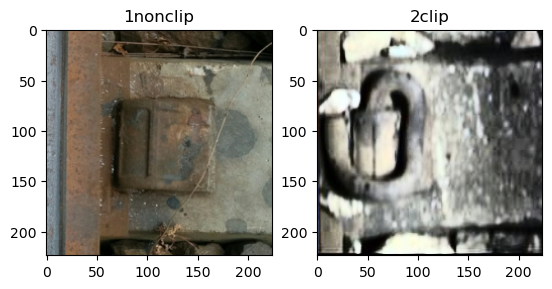

In [15]:
nonClipImage, nonClipClassName = getImageFromDataset(fastenerTrainDataset, 4)
clipExistImage, clipExistClassName = getImageFromDataset(fastenerTrainDataset, 700)

_, figure = plt.subplots(1,2)

figure[0].imshow(nonClipImage)
figure[0].title.set_text(nonClipClassName)

figure[1].imshow(clipExistImage)
figure[1].title.set_text(clipExistClassName)
plt.show()

## 3.4 Define simple CNN network for fastener classification based on VGG-8.
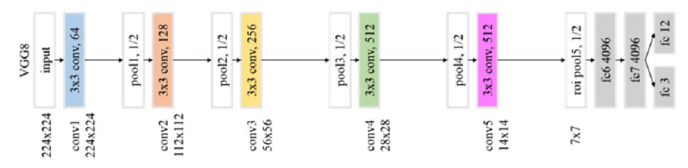


In [16]:
### Build simple CNN ###
class simpleFastenerNet(nn.Module):
  def __init__(self):
    super(simpleFastenerNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc6 = nn.Linear(512*7*7, 4096)
    self.fc7 = nn.Linear(4096, 2)


  def forward(self, input): # 1 x 3 x 224 x 224
    x = self.pool1(F.relu(self.conv1(input)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = self.pool4(F.relu(self.conv4(x)))
    x = self.pool5(F.relu(self.conv5(x))) # 512x7x7
    
    
    x = x.view(-1, 512*7*7)

    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x
  

## 3.5 Construct the model, optimizer and loss function

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda")
print(device)

cuda


In [18]:
net = simpleFastenerNet()
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

fastenerTrainDatasetLoader = DataLoader(fastenerTrainDataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
fastenerTestDatasetLoader = DataLoader(fastenerTestDataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

/home/andre/anaconda3/envs/CV/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


## 3.6 Train the model

In [43]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader), ncols=100)
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData
      
      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )
    
      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):
  
  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:', ncols=100):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader), ncols=100)
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)
    
      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)
    
      loss.backward()
      optimizer.step()
      

      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)
    
    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [20]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(fastenerTrainDatasetLoader, fastenerTestDatasetLoader, 
                                                                    net, 
                                                                    optimizer, scheduler, criterion, 
                                                                    trainEpoch=5)

Overall Training Progress::   0%|                                             | 0/5 [00:00<?, ?it/s]

Epoch 1 / 5


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 2 / 5


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 3 / 5


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 4 / 5


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 5 / 5


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

## 3.7 Find the confusion matrix and calculate TP, TN, FP, and FN

In [21]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

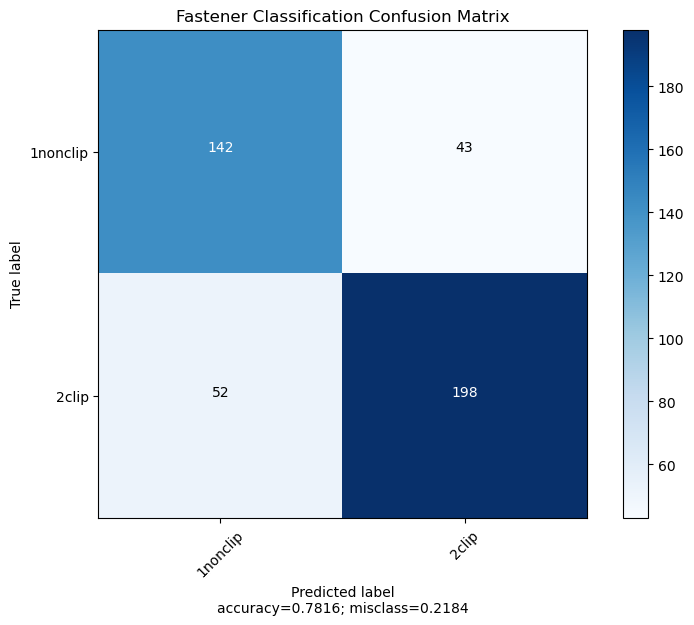

TP:142 TN:43 FP:52 FN:198


In [22]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix, 
                      normalize    = False,
                      target_names = fastenerTrainDataset.classes,
                      title        = "Fastener Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

In [23]:
#### Calculcate  Specificity, Sensitivity ###
sensitivity = tp / (tp+fn)
specificity = tn / (fp+tn)

## 3.8 Show Classification Results

In [24]:
def showRandomSamples(labels, predicted, testDataset, sampleNum=5):
  equals = labels == predicted
  correctIdx = np.where(equals == 1)[0].tolist()
  incorrectIdx = np.where(equals == 0)[0].tolist()

  randomCorrectIdx = random.sample(correctIdx, sampleNum)
  randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

  _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

  ### Plot Correct ###
  for imageIdx in range(len(randomCorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomCorrectIdx[imageIdx])
    figure[0,imageIdx].imshow(image,cmap='gray')
    figure[0,imageIdx].title.set_text('[CORRECT] '+className)

  for imageIdx in range(len(randomIncorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomIncorrectIdx[imageIdx])
    figure[1,imageIdx].imshow(image,cmap='gray')
    predictedClassName = testDataset.classes[predicted[randomIncorrectIdx[imageIdx]]]
    figure[1,imageIdx].title.set_text('Actual:'+className+' Predicted:' + predictedClassName)

  plt.show()

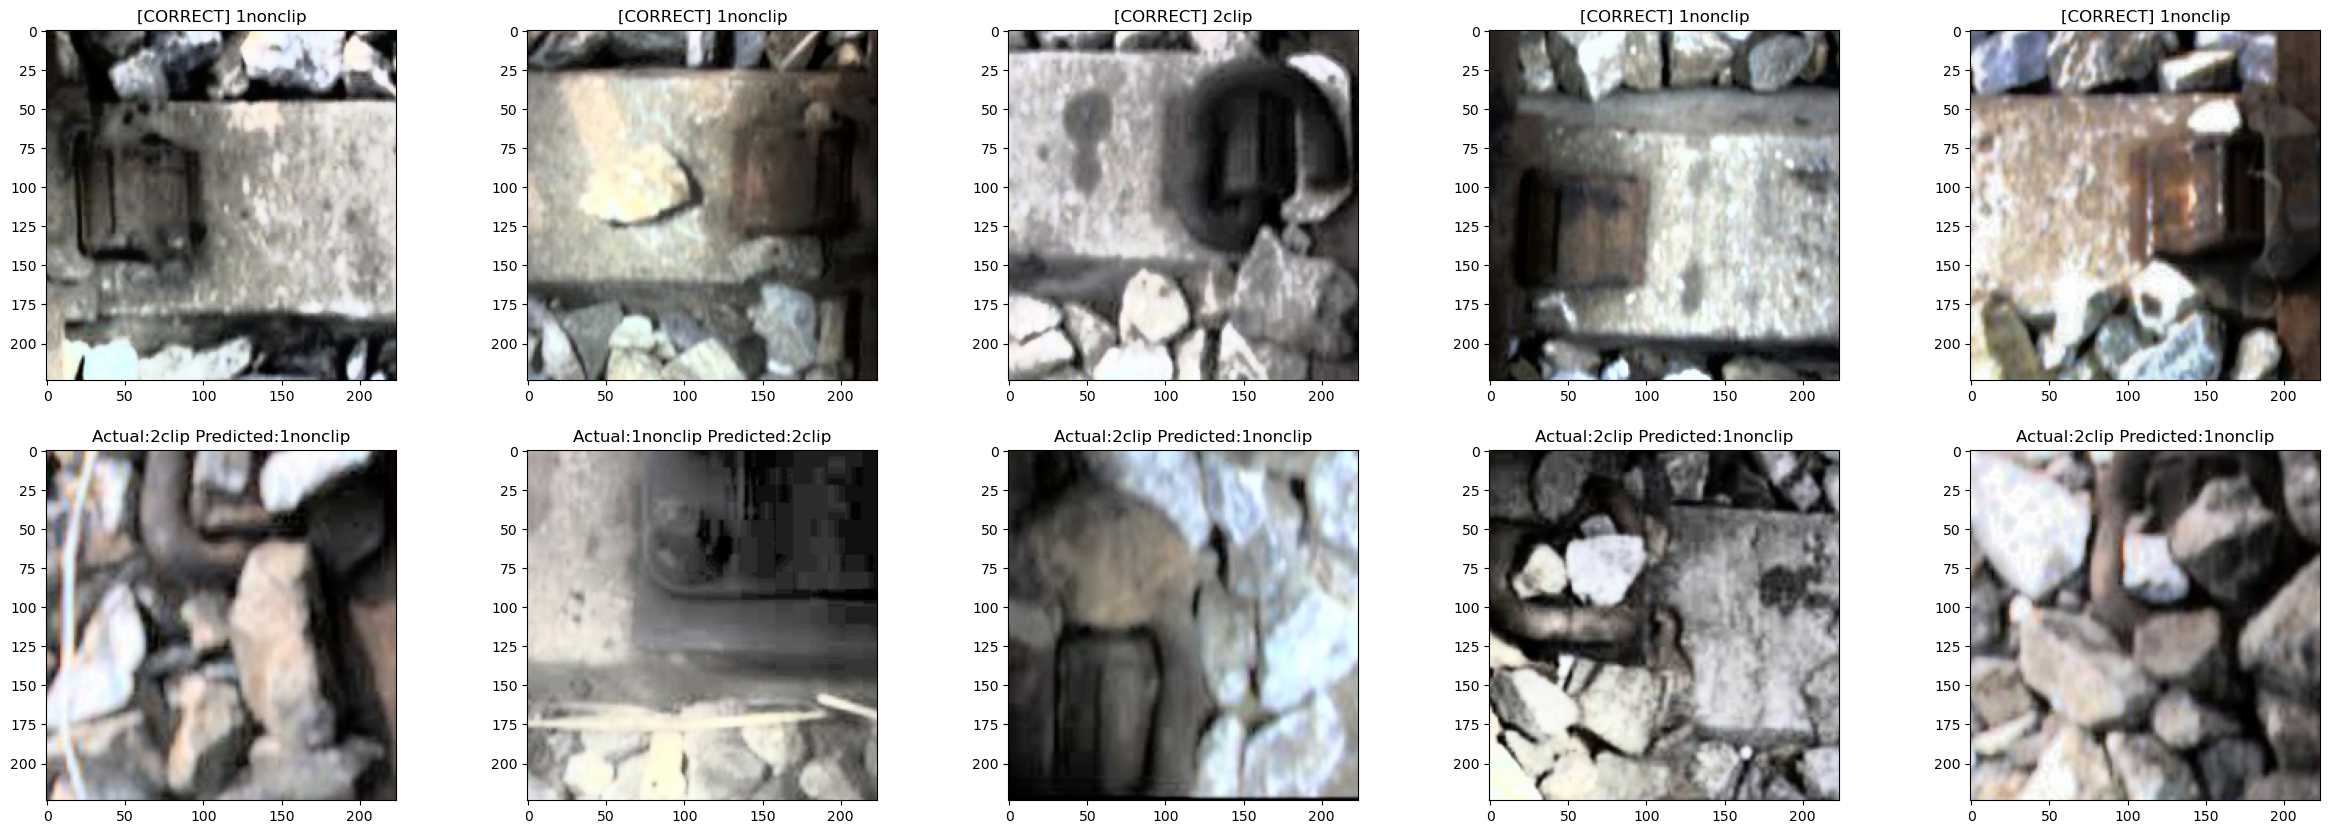

In [25]:
showRandomSamples(allLabels,bestPredicted,fastenerTestDataset,sampleNum=5)

## 3.9 Transfer learning from pretrained model

Available pretrained models in PyTorch : https://pytorch.org/docs/stable/torchvision/models.html

In [27]:
pretrainNet = models.resnet34(pretrained=True)
pretrainNet.fc = nn.Linear(512, 2)
pretrainNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrainNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

fastenerTrainDatasetLoader = DataLoader(fastenerTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
fastenerTestDatasetLoader = DataLoader(fastenerTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

In [28]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(fastenerTrainDatasetLoader, fastenerTestDatasetLoader, 
                                                                    pretrainNet, 
                                                                    optimizer, scheduler, criterion, 
                                                                    trainEpoch=10)

Overall Training Progress::   0%|                                            | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 2 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 3 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 4 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 5 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 6 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 7 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 8 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 9 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

Epoch 10 / 10


  0%|                                                                        | 0/71 [00:00<?, ?it/s]

  0%|                                                                        | 0/28 [00:00<?, ?it/s]

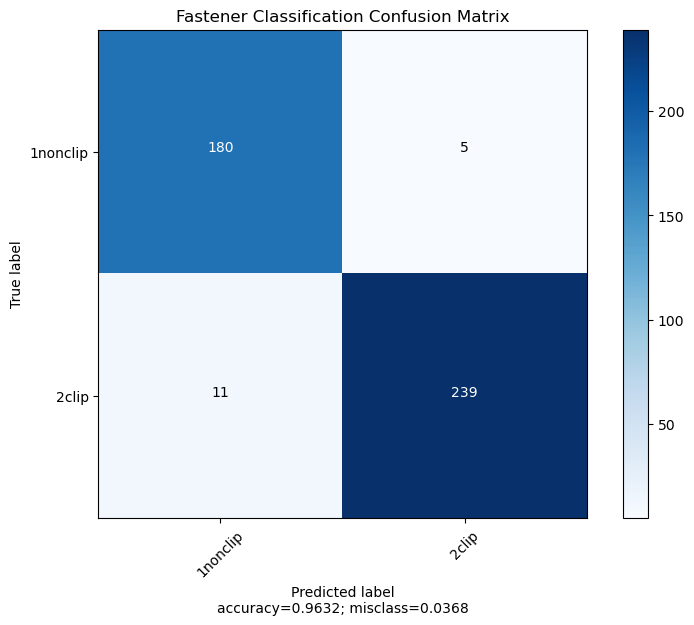

TP:180 TN:5 FP:11 FN:239


In [29]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix, 
                      normalize    = False,
                      target_names = fastenerTrainDataset.classes,
                      title        = "Fastener Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

# 4.Exercise on real world dataset : Chest X-Ray Images (Pneumonia) 
This dataset is taken from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
![Dataset samples](https://i.imgur.com/jZqpV51.png)

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

In [30]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.7 MB/s eta 0:00:001.6 MB/s eta 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 1.2 MB/s eta 0:00:0031m2.6 MB/s eta 0:00:01


In [31]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix

from captum.attr import LayerGradCam, LayerAttribution
# To guarantee reproducible results 
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2)

## 4.1 GPU status check

In [32]:
!nvidia-smi

Fri Mar 22 21:18:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        On  | 00000000:01:00.0  On |                  N/A |
|  0%   41C    P8              13W / 340W |   4576MiB / 16376MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 4.2 Download and inspect pneumonia chest-xray dataset

In [35]:
# !wget -O assets/Lab8/chest_xray.zip https://www.piclab.ai/classes/cv2020/chest_xray.zip
!unzip -qo assets/Lab8/chest_xray.zip

--2024-03-22 21:27:47--  https://www.piclab.ai/classes/cv2020/chest_xray.zip
Resolving www.piclab.ai (www.piclab.ai)... 161.200.92.132
Connecting to www.piclab.ai (www.piclab.ai)|161.200.92.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1226148659 (1.1G) [application/zip]
Saving to: ‘assets/Lab8/chest_xray.zip’

assets/Lab8/chest_x  18%[==>                 ] 215.98M  --.-KB/s    in 7m 53s  

2024-03-22 21:35:40 (468 KB/s) - Read error at byte 226475581/1226148659 (Connection reset by peer). Retrying.

--2024-03-22 21:35:41--  (try: 2)  https://www.piclab.ai/classes/cv2020/chest_xray.zip
Connecting to www.piclab.ai (www.piclab.ai)|161.200.92.132|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 1226148659 (1.1G), 999673078 (953M) remaining [application/zip]
Saving to: ‘assets/Lab8/chest_xray.zip’

assets/Lab8/chest_x 100%[+++================>]   1.14G  1.71MB/s    in 12m 7s  

2024-03-22 21:47:50 (1.31 MB/s) - ‘assets/L

In [36]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [59]:
### Dataset Augmentation (https://pytorch.org/docs/stable/torchvision/transforms.html) ###
transformTrain = transforms.Compose([        
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

transformTest =  transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

### Dataloader for our dataset ###
pneumoniaTrainDataset = ImageFolder('chest_xray/train/', transform=transformTrain)
pneumoniaTestDataset = ImageFolder('chest_xray/test/', transform=transformTest)

print('Total train set images :', len(pneumoniaTrainDataset))
print('Total test set images :', len(pneumoniaTestDataset))

Total train set images : 5216
Total test set images : 624



## 4.3 Dataset visualization

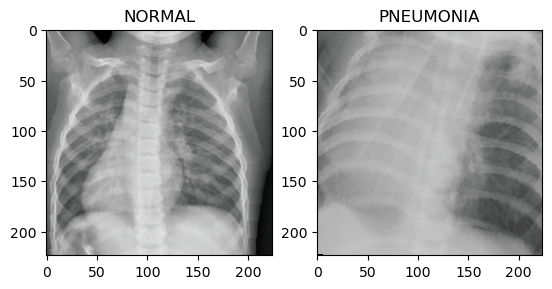

In [38]:
normalImage, normalClassName = getImageFromDataset(pneumoniaTrainDataset, 0)
pneumoniaImage, pneumoniaClassName = getImageFromDataset(pneumoniaTrainDataset, 3000)


_, figure = plt.subplots(1,2)

figure[0].imshow(normalImage,cmap='gray')
figure[0].title.set_text(normalClassName)

figure[1].imshow(pneumoniaImage,cmap='gray')
figure[1].title.set_text(pneumoniaClassName)
plt.show()

## 4.4 Define CNN network for pneumonia classification based on modified VGG-8
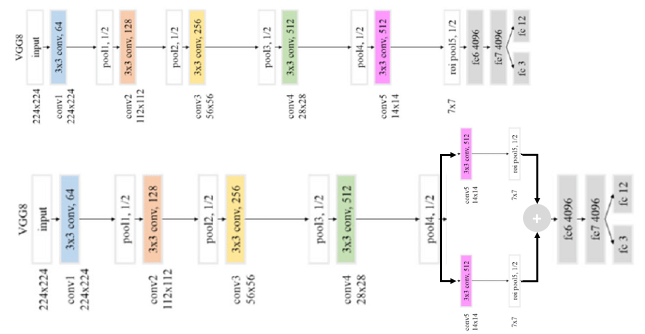

In [39]:
### Build simple CNN ###
class pneumoniaNet(nn.Module):
  def __init__(self):
    super(pneumoniaNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc6 = nn.Linear(512*7*7, 4096)
    self.fc7 = nn.Linear(4096, 2)


  def forward(self, input): # 1 x 3 x 224 x 224
    x = self.pool1(F.relu(self.conv1(input)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = self.pool4(F.relu(self.conv4(x)))

    ###
   
    ###
    x = x.view(-1, 512*7*7) ### change to (1,25088)
    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x

### 4.4 Solution
click "cell hidden" to show the solution

In [52]:
### Build simple CNN ###
class pneumoniaNet(nn.Module):
  def __init__(self):
    super(pneumoniaNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc6 = nn.Linear(512*7*7, 4096) ### (inputnode=25088, outputnode=4096)
    self.fc7 = nn.Linear(4096, 2)


  def forward(self, input): # 1 x 3 x 224 x 224
    x = self.pool1(F.relu(self.conv1(input)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = self.pool4(F.relu(self.conv4(x)))
  
    x_5_1 = self.pool5_1(F.relu(self.conv5_1(x)))
    x_5_2 = self.pool5_2(F.relu(self.conv5_2(x)))

    x = x_5_1 + x_5_2 ### output size of this line is (512,7,7)
    x = x.view(-1, 512*7*7) ### change to (1,25088)

    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x
from torchinfo import summary
summary(pneumoniaNet().cuda(), (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
pneumoniaNet                             [1, 2]                    --
├─Conv2d: 1-1                            [64, 224, 224]            1,792
├─MaxPool2d: 1-2                         [64, 112, 112]            --
├─Conv2d: 1-3                            [128, 112, 112]           73,856
├─MaxPool2d: 1-4                         [128, 56, 56]             --
├─Conv2d: 1-5                            [256, 56, 56]             295,168
├─MaxPool2d: 1-6                         [256, 28, 28]             --
├─Conv2d: 1-7                            [512, 28, 28]             1,180,160
├─MaxPool2d: 1-8                         [512, 14, 14]             --
├─Conv2d: 1-9                            [512, 14, 14]             2,359,808
├─MaxPool2d: 1-10                        [512, 7, 7]               --
├─Conv2d: 1-11                           [512, 14, 14]             2,359,808
├─MaxPool2d: 1-12                        [512, 7, 7]

## 4.5 Construct the model, optimizer and loss function



In [41]:
pneuNet = pneumoniaNet()

### 4.5.1 Network Debugging

In [42]:
output = pneuNet(torch.zeros((1,3,224,224)))

In [44]:
pneuNet.cuda()

### TODO : Add loss function and Adam optimizer ##
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pneuNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

pneumoniaTrainDatasetLoader = DataLoader(pneumoniaTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
pneumoniaTestDatasetLoader = DataLoader(pneumoniaTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/home/andre/anaconda3/envs/CV/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### 4.5 Solution

In [45]:
#@title
pneuNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pneuNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

pneumoniaTrainDatasetLoader = DataLoader(pneumoniaTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
pneumoniaTestDatasetLoader = DataLoader(pneumoniaTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

## 4.5 Train the model

In [46]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader), ncols=100)
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData
      
      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )
    
      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):
  
  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:', ncols=100):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader), ncols=100)
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)
    
      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)
    
      loss.backward()
      optimizer.step()
      

      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)
    
    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [49]:
### TODO : Train the model by using trainAndTestModel function ###
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(pneumoniaTrainDatasetLoader, pneumoniaTestDatasetLoader, pneuNet, optimizer, scheduler, criterion,
                                       trainEpoch=3)

Overall Training Progress::   0%|                                             | 0/3 [00:00<?, ?it/s]

Epoch 1 / 3


  0%|                                                                       | 0/326 [00:00<?, ?it/s]

  0%|                                                                        | 0/39 [00:00<?, ?it/s]

Epoch 2 / 3


  0%|                                                                       | 0/326 [00:00<?, ?it/s]

  0%|                                                                        | 0/39 [00:00<?, ?it/s]

Epoch 3 / 3


  0%|                                                                       | 0/326 [00:00<?, ?it/s]

  0%|                                                                        | 0/39 [00:00<?, ?it/s]

### 4.5 Solution
click "cell hidden" to show the solution

In [ ]:
#@title
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(pneumoniaTrainDatasetLoader, pneumoniaTestDatasetLoader, 
                                                                    pneuNet, 
                                                                    optimizer, scheduler, criterion, 
                                                                    trainEpoch=3)

## 4.6 Find the confusion matrix and calculate TP, TN, FP, and FN

In [51]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

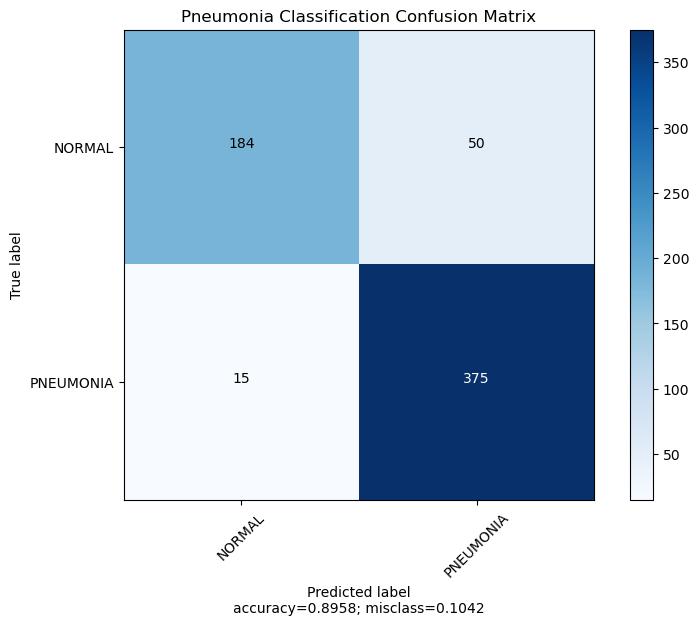

TP:184 TN:50 FP:15 FN:375


In [53]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix, 
                      normalize    = False,
                      target_names = pneumoniaTrainDataset.classes,
                      title        = "Pneumonia Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

## 4.7 Show Classification Results

In [54]:
def showRandomSamples(labels, predicted, testDataset, sampleNum=5):
  equals = labels == predicted
  correctIdx = np.where(equals == 1)[0].tolist()
  incorrectIdx = np.where(equals == 0)[0].tolist()

  randomCorrectIdx = random.sample(correctIdx, sampleNum)
  randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

  _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

  ### Plot Correct ###
  for imageIdx in range(len(randomCorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomCorrectIdx[imageIdx])
    figure[0,imageIdx].imshow(image,cmap='gray')
    figure[0,imageIdx].title.set_text('[CORRECT] '+className)

  for imageIdx in range(len(randomIncorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomIncorrectIdx[imageIdx])
    figure[1,imageIdx].imshow(image,cmap='gray')
    predictedClassName = testDataset.classes[predicted[randomIncorrectIdx[imageIdx]]]
    figure[1,imageIdx].title.set_text('Actual:'+className+' Predicted:' + predictedClassName)

  plt.show()

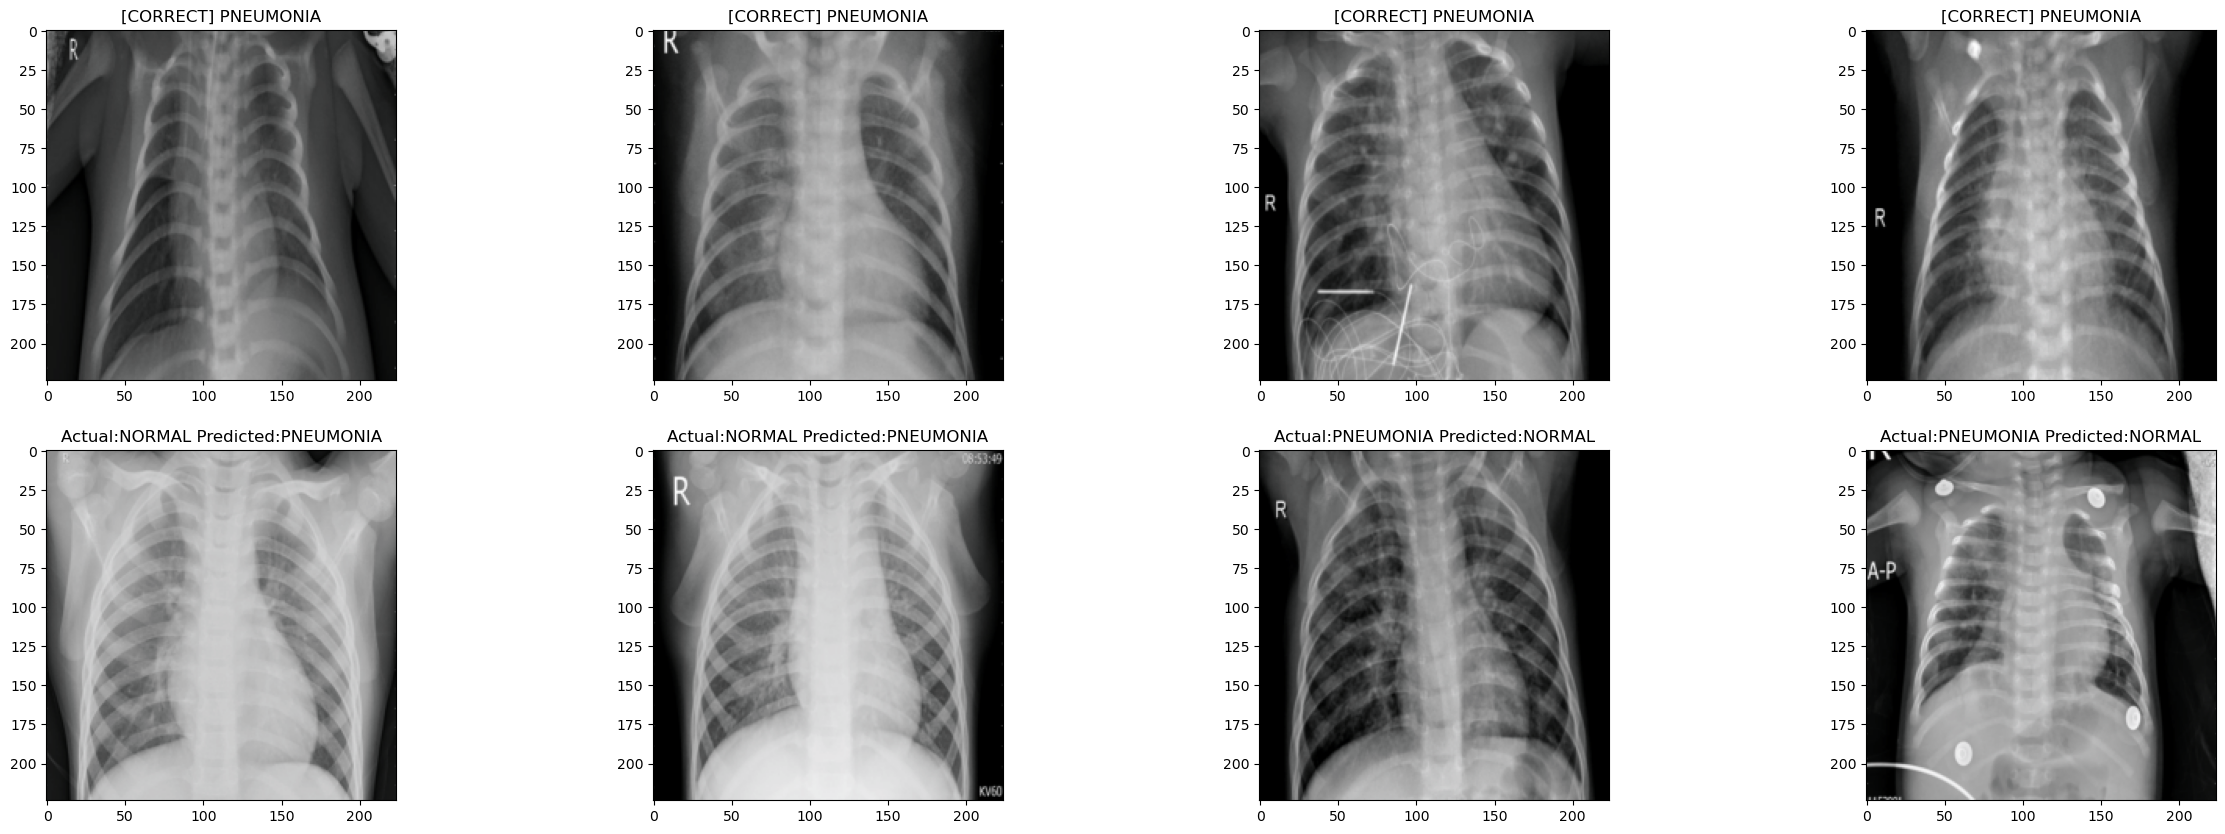

In [55]:
showRandomSamples(allLabels,bestPredicted,pneumoniaTestDataset,sampleNum=4)

## 4.8 Model Interpretability with GradCAM

In [56]:
def getLayer(model, layerName):
    for name in layerName.split("."):
        model = getattr(model, name)
    return model

def scale(x):
    x -= x.min()
    x /= x.max() + np.spacing(1)
    x *= 255
    return np.array(x, dtype=np.uint8)

def overlayHeatmap(img, grad):
    imgnp = np.array(img)
    grad = grad.squeeze().cpu().detach().numpy()
    gradImg = scale(grad)
    heatmap = cv2.applyColorMap(gradImg, cv2.COLORMAP_JET)
    heatmap = heatmap[:, :, ::-1] # convert to rgb
    return cv2.addWeighted(imgnp, 0.5, heatmap, 0.5, 0)

def attribute(preprocImageTensor, originalInputImage ,net ,layername):
    output = net(preprocImageTensor)
    classNo = torch.argmax(output)
    
    
    intermediateLayer = getLayer(net, layername)
    layerGC = LayerGradCam(net, intermediateLayer)
    
    attr = layerGC.attribute(preprocImageTensor, classNo)
    heatmap = overlayHeatmap(originalInputImage, LayerAttribution.interpolate(attr, originalInputImage.shape[0:2], 'bilinear'))
    return heatmap, classNo.item()

torch.Size([1, 3, 224, 224])


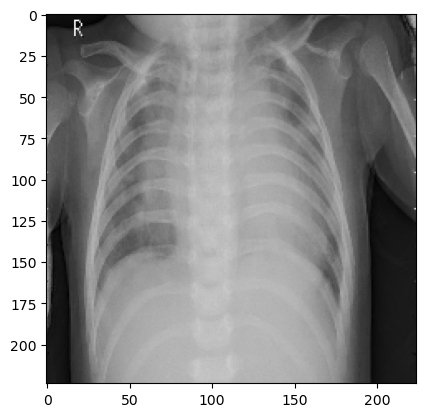

In [57]:
sampleImage = cv2.imread('chest_xray/test/PNEUMONIA/person112_bacteria_538.jpeg')
sampleImage = cv2.resize(sampleImage, (224,224))
plt.imshow(sampleImage)

sampleTensor = ((sampleImage / 255) - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]

sampleTensor = torch.from_numpy(sampleTensor).permute(2,0,1).unsqueeze(0).float().cuda()
sampleTensor.cuda()
print(sampleTensor.shape)

1


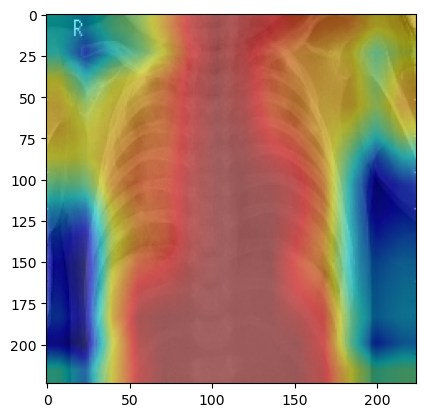

In [58]:
heatMap, classNo = attribute(sampleTensor, sampleImage, bestNet, 'conv5_1') # We typically attach gradcam to last convolution layer
plt.imshow(heatMap)
print(classNo)